In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

### Problem Statement

[Rain or Shine](https://www.rainorshineicecream.com) is an ice cream shop with 3 locations in Vancouver. The business is open all year and the daily revenue depends on the weather. In particular, revenue increases with temperature and decreases with precipitation. The data file `weather.csv` includes daily average temperature (in degrees Celsius) and daily precipitation (in millimeters) from January 1, 1997 through December 31, 2022. Construct a mathematical model of total annual revenue at one of the shop locations.

### Variables and Parameters

| Description | Symbol | Dimensions | Type |
| :---: | :---: | :---: | :---: |
| average daily temperature | $T$| $\Theta$ | random variable |
| total daily precipitation | $P$| L | random variable |
| reference temperature | $T_0$ | $\Theta$ | parameter |
| reference precipitation | $P_0$ | L | parameter |
| reference number of customers | $C_0$ | N | parameter |
| total revenue | $R$| $1$ | random variable |
| a | $a$| $1$ | parameter |
| b | $b$| $1$ | parameter |

**Formula:** 

$R_i = 10 * max\{C_0 + a(T - T_0) - b(P - P_0),0\}$

$R_{total} = \sum \limits_{i = 1}^{365} R_i$

### Assumptions and Constraints

**Assumptions:**
* Daily precipitation follows a gamma distribution $\Gamma(\alpha,\beta)$
* Daily customers function is linear with respect to temperature and precipitation
* Daily customers function take the form $C(T,P) = \max \{ c(T,P) , 0 \}$ where $c(T,P) = C_0 + a(T - T_0) - b(P - P_0)$
* On a nice day where the average temperature is $T_0 = 25$ and precipitation is $P_0 = 0$ the total number of customers is $C_0 = 720$ (which corresponds to serving one customer per minute over a 12 hour business day)
* $T$ and $P$ on any given day are independent

**Constraints:**
* Each customer spends 7 dollars
* Total Revenue $= 7 * C(T,P)$

### Build Solutions

In [2]:
# Check the data
df = pd.read_csv('weather.csv')
df.head()

,year,month,day,avg_temperature,precipitation
0,2022,12,31,5.90,3.8
1,2022,12,30,7.80,12.7
2,2022,12,29,4.84,2.9
3,2022,12,28,5.80,3.8
4,2022,12,27,8.10,28.8


#### Kernel Density Estimate of Temperature

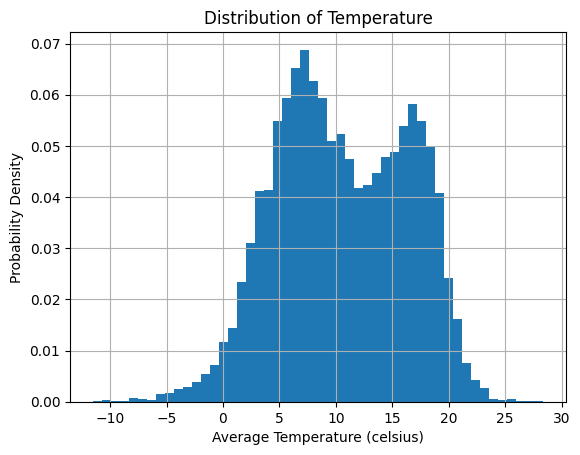

In [3]:
# Plot histogram of temperature data
plt.hist(df['avg_temperature'], bins=50, density=True)
plt.title('Distribution of Temperature')
plt.xlabel('Average Temperature (celsius)')
plt.ylabel('Probability Density')
plt.grid()
plt.show()

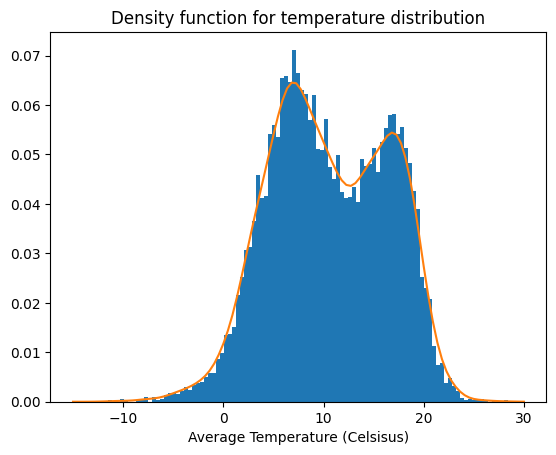

In [4]:
# Estimate the probability density function of temperature distribution with gaussian_kde
kdeT = stats.gaussian_kde(df['avg_temperature'])
x = np.linspace(-15,30, 100)
df['avg_temperature'].hist(bins=100,density=True)
plt.plot(x,kdeT(x))
plt.xlabel('Average Temperature (Celsisus)')
plt.title('Density function for temperature distribution')
plt.grid()
plt.show()

Note: We expect the parameter $\alpha < 1$ therefore the probability distribution $f(x)$ satistifes $\lim \limits_{x \to 0^+} f(x) = \infty$.

#### Kernel Density Estimate of Precipitation

In [5]:
# compute mean of precipitation
mu_p = df['precipitation'].mean()

# compute variance of precipitation
sigma2 = df['precipitation'].var()
print('mean =', mu_p, 'variance =', sigma2)

mean = 3.2037068239258635 variance = 41.88987356711931


In [6]:
# Calculate the rate and shape to fit into gamma distribution
alpha = (mu_p**2)/sigma2
beta = sigma2/mu_p
print(alpha)
print(beta)

0.2450171494842008
13.07543913015952


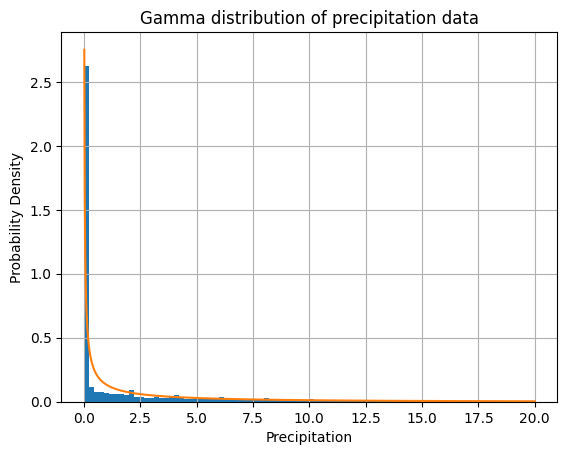

In [7]:
import scipy.special as sps
from scipy.stats import gamma 

df['precipitation'].hist(bins = 90, density = True, range = (0, 20))
x = np.linspace(0, 20, 1000)
pdfP = gamma.pdf(x, alpha, scale=beta)
plt.plot(x, pdfP)
plt.title('Gamma distribution of precipitation data')
plt.xlabel('Precipitation')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

$$
R_{total} = \sum \limits_{i = 1}^{365} R_i
$$

where $R_i$ is the revenue on day $i$.

In [8]:
Ys = []

# creating samples
# $R_i = 10 * max\{C_0 + a(T - T_0) - b(P - P_0),0\}$
# $R_i = 10 * max\{C_0 + T - T_0 - P),0\}$
# assume a = b = 1

for i in range(1000):
    T = kdeT.resample(size=365).flatten()
    P = stats.gamma.rvs(alpha, loc=0, scale=beta, size = 365)
    c = np.sum(720 + T - 25 - P)
    Y = np.maximum(c,0) # ensures revenue is positive
    R = 7*Y
    Ys.append(R)

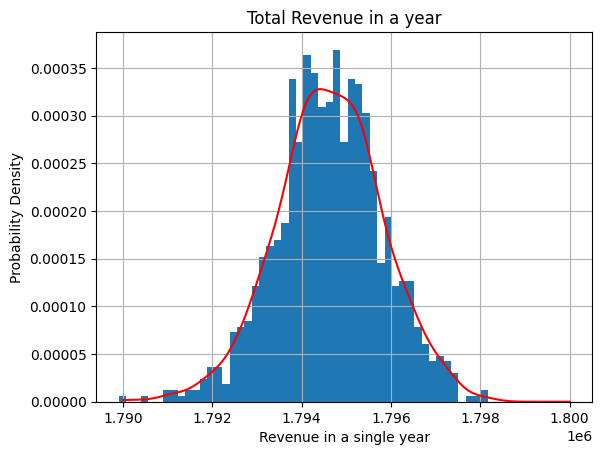

In [9]:
kdeY = stats.gaussian_kde(Ys)
x = np.linspace(1790000,1800000,3000)
plt.hist(Ys, bins=50, density=True)
plt.plot(x,kdeY.pdf(x),'r')
plt.title('Total Revenue in a year')
plt.xlabel('Revenue in a single year')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

In [11]:
from scipy.integrate import quad

mean,_ = quad(lambda x: x*kdeY.pdf(x),1790000,1800000)
var, _ = quad(lambda x: (x - mean)**2 * kdeY.pdf(x), 1790000,1800000)

skew_num, _ = quad(lambda x: ((x - mean) ** 3) * kdeY.pdf(x), 1790000, 1800000)
skewness = skew_num / (np.sqrt(var) ** 3)

print('mean =', mean, 'variance =', var)
print('Skewness =', skewness)

mean = 1793376.5216852436 variance = 3050477.945289186
Skewness = 1.3819432823636277


### Analysis

#### How do the values $C_0$, $T_0$ and $P_0$ change the model?

1. **Reference Temperature $T_0$:**

$T_0 = 25^\circ C$ serves as a reference point on what is considered a good day for customers to get ice-cream. When $T > T_0$ (example = $ T = 30^\circ C$), then the revenue on that particular day increases, because people are more likely to buy ice cream. That is why when we increase the reference point of $T_0$, it is harder to get the ideal temperature of ice-cream based on the histogram of average temperature data, decreasing the revenue. In the same way, when we decrease $T_0$, it makes the 'ideal' weather easier to achieve, increasing the number of customers and revenue.

2. **Reference Precipitation $P_0$:**

$P_0$ represents a day with no rain, which is ideal for customers to visit the ice cream shop. When $P > P_0$, the number of customers decreases because people avoid going out when it's rainy. Increasing $P_0$ means that weather conditions with some precipitation are still considered good, and based on the gamma distribution of precipitation, it is easier to achieve the good weather, hence increasing customer and revenue. 

3. **Reference Number of Customers $C_0$:** 

$C_0$ is the expected number of customer on a nice day at $T_0 = 25^\circ C$ and $P_0 = 0$. We assume that $C_0$ represents the expected number of customer count on ideal weather conditions, so increasing $C_0$ means the rain or shine expects more customers, leading to higher total revenue. Similarly, decreasing $C_0$ means that the shop expects fewer customers under ideal weather, leading to lower total revenue.

#### Find a value $R_0$ such that $P(R > R_0) = 0.9$



In [12]:
R_0 = np.percentile(Ys, 10)
print(R_0)

1793148.401491134


Based on the model above, there is a 90% chance that the total revenue in a year is greater than $1,793,148.40. In most years, the revenue will exceed the threshold, so if annual expenses are greater than that, then Rain or Shine may face a deficit. 

#### Finding the 95% Confidence Interval

In [14]:
print(kdeY.integrate_box_1d(mean-2*np.sqrt(var),  mean+2*np.sqrt(var)))
print(mean-2*np.sqrt(var))
print(mean+2*np.sqrt(var))

0.96597775496268
1789883.398185973
1796869.645184514


The distribtion of the model is rougly a normal distribution and 95% of the data falls within $\mu$ $\pm$ 2 $\sigma$, so the output indicates that there is a 95.23% chance that the total revenue will be within the range of $1789883.40 and $1796869.65 in a typical year.

#### How do the values $a$ and $b$ change the model?


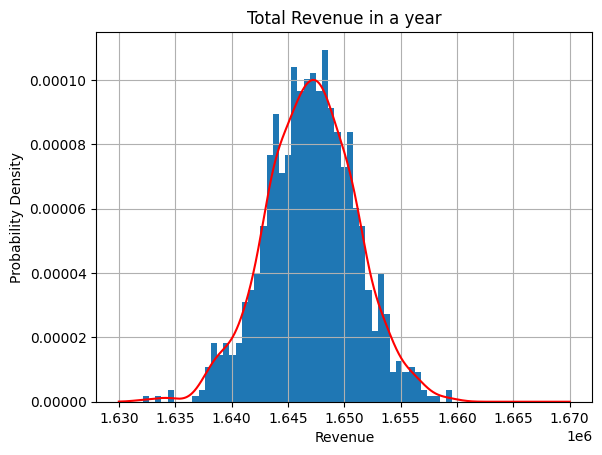

In [28]:
Ys = []
a = 5
b = 1
for i in range(1000):
    T = kdeT.resample(size=365).flatten()
    P = stats.gamma.rvs(alpha, loc=0, scale=beta, size = 365)
    c = np.sum(720 + a * T - a * 25 - b * P)
    Y = np.maximum(c,0) # ensures revenue is positive
    R = 7*Y
    Ys.append(R)
    
kdeY = stats.gaussian_kde(Ys)
x = np.linspace(1630000,1670000,10000)
plt.hist(Ys, bins=50, density=True)
plt.plot(x,kdeY.pdf(x),'r')
plt.title('Total Revenue in a year')
plt.xlabel('Revenue')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

In [29]:
mean,_ = quad(lambda x: x*kdeY.pdf(x),1630000,1670000)
var, _ = quad(lambda x: (x - mean)**2 * kdeY.pdf(x), 1630000,1670000)

skew_num, _ = quad(lambda x: ((x - mean) ** 3) * kdeY.pdf(x), 1630000, 1670000)
skewness = skew_num / (np.sqrt(var) ** 3)

print('mean =', mean, 'variance =', var)
print('Skewness =', skewness)

mean = 1647030.5291108103 variance = 16592087.9247166
Skewness = -0.04818054133223685


When a is increased, the importance on temperature increases. This will lower the expected total annual revenue because it indicates that with a strong influence from temperature, the effect of better weather conditions may not be enough to offset other conditions as strongly. This is reflected from the skewness as it changed from positive to slightly negative, which means there is a likelihood of lower revenue years than high. 

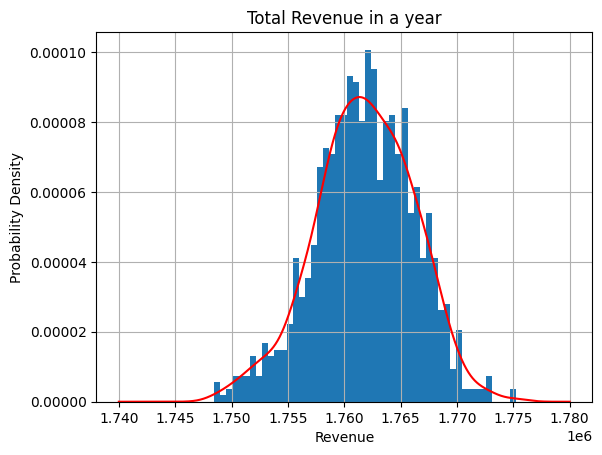

In [30]:
Ys = []
a = 1
b = 5
for i in range(1000):
    T = kdeT.resample(size=365).flatten()
    P = stats.gamma.rvs(alpha, loc=0, scale=beta, size = 365)
    c = np.sum(720 + a * T - a * 25 - b * P)
    Y = np.maximum(c,0) # ensures revenue is positive
    R = 7*Y
    Ys.append(R)
    
kdeY = stats.gaussian_kde(Ys)
x = np.linspace(1740000,1780000,10000)
plt.hist(Ys, bins=50, density=True)
plt.plot(x,kdeY.pdf(x),'r')
plt.title('Total Revenue in a year')
plt.xlabel('Revenue')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

In [31]:
mean,_ = quad(lambda x: x*kdeY.pdf(x),1740000,1780000)
var, _ = quad(lambda x: (x - mean)**2 * kdeY.pdf(x), 1740000,1780000)

skew_num, _ = quad(lambda x: ((x - mean) ** 3) * kdeY.pdf(x), 1740000, 1780000)
skewness = skew_num / (np.sqrt(var) ** 3)

print('mean =', mean, 'variance =', var)
print('Skewness =', skewness)

mean = 1761787.4266800585 variance = 20485459.5143674
Skewness = -0.16841661142520775


Increasing b also decreases the expected revenue and significantly increases the variance. Since there is more importance on precipitation, this will lead to years with more rain to decrease in revenue and similar to increasing the importance of temperature, the model has higher likelihood of having lower revenue years. There is still a chance of good years with higher revenue, but having rain creates a larger impact on the revenue which is shown by the decrease in mean and increase in variance.

#### How does the model change if we assume that the amount each customer spends is normally distributed?

The new equation would be:
$$R_i = \mathcal{N}(\mu_s, \sigma_s) * max\{C_0 + a(T - T_0) - b(P - P_0),0\}$$
where $\mu_s$ is the mean amount spent per customer and $\sigma_s$ is the standard deviation.

The prices for Rain or Shine products are $4 for kids, $5 for single flavor, $5.5 for two flavors, $7 for double, $10.5 for pint, and $11 for flight. 

In [18]:
prices = [4, 5, 5.5, 7, 10.5, 11]

mu_s = np.mean(prices)
sigma_s = np.std(prices)
print('mean =', mu_s, 'std =', sigma_s)

mean = 7.166666666666667 std = 2.6874192494328497


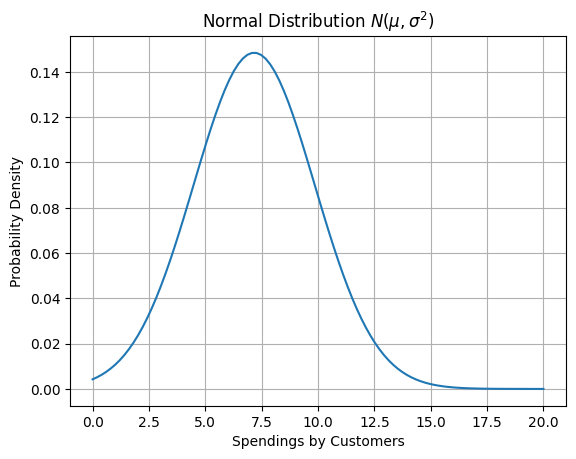

In [19]:
x = np.linspace(0,20,100)
y = stats.norm.pdf(x, loc = mu_s, scale = sigma_s)
plt.plot(x, y)
plt.title('Normal Distribution $N(\mu, \sigma^2)$')
plt.xlabel('Spendings by Customers')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

Based on the normal distribution above, it doesn't make sense for customers to have negative spending or spend below $4. If that is the case, then the new model will predict a lower revenue range. Thus, it is better to use a truncated normal distribution to prevent the amount of spending to go out of range.

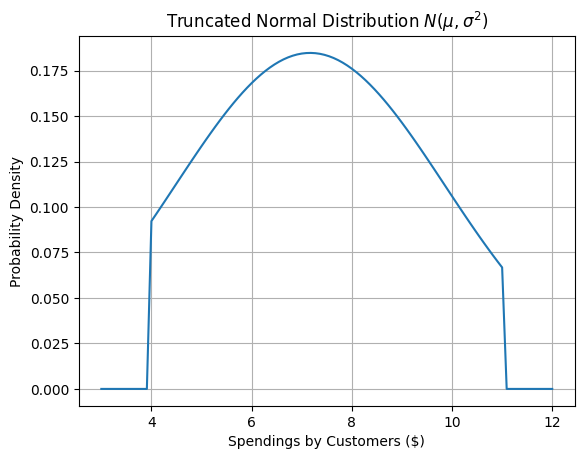

In [20]:
from scipy.stats import truncnorm

l = (4 - mu_s) / sigma_s
u = (11 - mu_s) / sigma_s
x = np.linspace(3,12,100)
y = stats.truncnorm.pdf(x, l, u, loc = mu_s, scale = sigma_s)
plt.plot(x, y)
plt.title('Truncated Normal Distribution $N(\mu, \sigma^2)$')
plt.xlabel('Spendings by Customers ($)')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

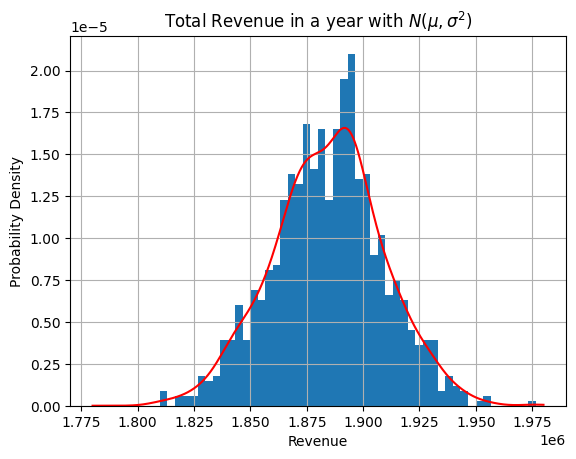

In [21]:
Ys = []
a = 1
b = 1
for i in range(1000):
    S = stats.truncnorm.rvs(l, u, loc=mu_s,scale=sigma_s,size = 365)
    T = kdeT.resample(size=365).flatten()
    P = stats.gamma.rvs(alpha, loc=0, scale=beta, size = 365)
    c = np.sum(S * (720 + a*(T - 25) - b*P))
    R = np.maximum(c,0)
    Ys.append(R)
    
kdeY = stats.gaussian_kde(Ys)
x = np.linspace(1780000,1980000,1000)
plt.hist(Ys, bins=50, density=True)
plt.plot(x, kdeY.pdf(x),'r')
plt.title('Total Revenue in a year with $N(\\mu, \\sigma^2)$')
plt.xlabel('Revenue')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

In [22]:
mean,_ = quad(lambda x: x*kdeY.pdf(x),1780000,1980000)
var, _ = quad(lambda x: (x - mean)**2 * kdeY.pdf(x), 1780000,1980000)

skew_num, _ = quad(lambda x: ((x - mean) ** 3) * kdeY.pdf(x), 1780000, 1980000)
skewness = skew_num / (np.sqrt(var) ** 3)

print('mean =', mean, 'variance =', var)
print('Skewness =', skewness)

mean = 1883887.5664164838 variance = 634198054.5496199
Skewness = 0.015583441594273346


Using a normal distribution to the model adds more variability that reflects real-world values more than using an assumption of the average of consumers' spendings. On average, customers are spending more than $7, so total revenue is higher, which is reflected by the mean. Since revenue is influenced by both weather and spending, there isi a much higher variance. 

On the first model, there is a positive skew which means most years have revenue lower than the mean. After introducing the truncated normal distribution, the model is more symmetrical and there are less impact from rare high revenue years. The distribution becomes more stable and give a more consistent expectation of yearly revenue.

### Results

1. Model with constant customer spending:
    - Mean Revenue: 1,793,376.52
    - Variance: 3,050,477.95
    - Skewness: 1.38
2. Increasing weight of Temperature (a):
    - Mean Revenue: $1,647,030.53
    - Variance: 16,592,087.92
    - Skewness: -0.048 
3. Increasing weight of Precipitation (b):
    - Mean Revenue: 1,761,787.43
    - Variance: 20,485,459.51
    - Skewness: -0.168
4. Model with Truncated Normal Distribution for Consumer Spending:
    - Mean Revenue: $1,883,887.57
    - Variance: 634,198,054.55
    - Skewness: 0.016

Both the temperature and precipitation significantly influence the revenue model. If temperature has more significance, which is altered by increasing a, revenue tends to be lower as lower temperatures have bigger effect on total revenue. Similarly, if precipitation is more impactful, by increasing b, there is an increase of likelihood of lower revenue years as shown by the jump in variance and the negative skewness.

By modeling customer spending on a truncated mormal distribution, the revenue model resembles the reality of consumer spending which leads to a wider spread of revenue outcomes as shown by the large variance. The shift of the skewness to be more symmetrical also highlights the effect of a more realistic behavior. 

By adjusting the parameters for weather conditions, customer behavior and other factors, the model can help forecast revenue for future years with a range of confidence. It is also possible to gain insights into expected revenue and make data-driven decisions on pricing, cost control, and operations. 

Further exploration:
- c(T,P) can be other form to model the number of customers per day